In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Himendra Makode\.cache\kagglehub\datasets\blastchar\telco-customer-churn\versions\1


In [3]:
# import LibrariLibraries 

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_curve, auc, classification_report)
import joblib


In [4]:
# Cell 2: Load dataset
df = pd.read_csv("Telco-Customer-Churn.csv")
print("Shape:", df.shape)
df.head()


Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


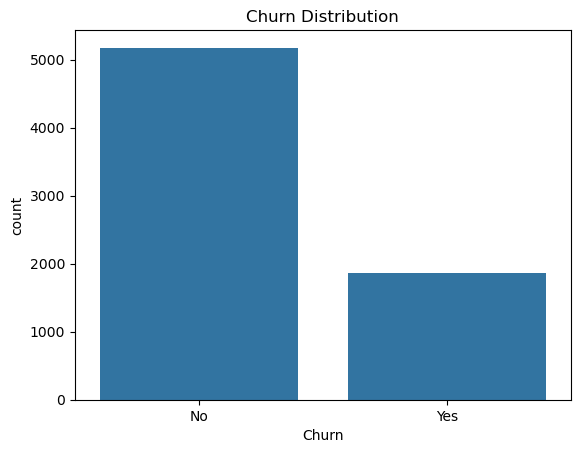

In [5]:
# Quick data overview / EDA
df.info()
df.describe(include='all').T

# Check churn balance
print(df['Churn'].value_counts())
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()


In [6]:
# Data cleaning notes (Telco dataset known quirks) ===
# There is sometimes a 'TotalCharges' column that looks numeric but contains spaces -> convert
if 'TotalCharges' in df.columns:
    # replace spaces with NaN then convert to float
    df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])
    # fill or drop missing TotalCharges (few rows)
    print("TotalCharges missing:", df['TotalCharges'].isna().sum())
    df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


TotalCharges missing: 11


C:\Users\Himendra Makode\AppData\Local\Temp\ipykernel_36932\717013466.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


In [7]:
# Feature selection & quick cleanup
# Drop customerID (identifier)
if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])

# Trim whitespace for string columns
for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].str.strip()

# Convert 'SeniorCitizen' (if 0/1 as int) to string to treat consistent with other categorical features
if 'SeniorCitizen' in df.columns and df['SeniorCitizen'].dtype != object:
    df['SeniorCitizen'] = df['SeniorCitizen'].astype(str)


In [8]:
# Encode categorical variables
# Identify categorical vs numeric
cat_cols = df.select_dtypes(include='object').columns.tolist()
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

# For binary categorical (Yes/No), map to 0/1
binary_map = {'Yes':1, 'No':0, 'Female':0, 'Male':1}
for c in cat_cols:
    unique_vals = df[c].nunique()
    if set(df[c].dropna().unique()).issubset(set(binary_map.keys())):
        df[c] = df[c].map(binary_map)


Categorical columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
Numeric columns: ['tenure', 'MonthlyCharges', 'TotalCharges']


In [9]:
# One-Hot encode remaining categoricals 
# Remaining categorical columns to get dummies (exclude target 'Churn' if still string)
if 'Churn' in df.columns and df['Churn'].dtype == object:
    df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

# find categorical columns that still are object dtype
cat_for_dummies = [c for c in df.select_dtypes(include='object').columns]
print("To one-hot:", cat_for_dummies)

df = pd.get_dummies(df, columns=cat_for_dummies, drop_first=True)
print("After dummies shape:", df.shape)


To one-hot: ['SeniorCitizen', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
After dummies shape: (7043, 31)


In [10]:
# Prepare X, y and train-test split 
y = df['Churn']
X = df.drop(columns=['Churn'])

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.mean(), y_test.mean())


(5634, 30) (1409, 30) 0.2655307064252751 0.26472675656493966


In [11]:
# Baseline models using pipeline (scaling + model) 
scaler = StandardScaler()

# Logistic Regression pipeline
pipe_lr = Pipeline([
    ('scaler', scaler),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
])
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)

# Random Forest (no scaling required, but keep pipeline for consistency)
pipe_rf = Pipeline([
    ('scaler', StandardScaler()), # optional
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42))
])
pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)

# Print metrics function
def print_metrics(y_true, y_pred, model_name):
    print(f"=== {model_name} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1:", f1_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    
print_metrics(y_test, y_pred_lr, "Logistic Regression")
print_metrics(y_test, y_pred_rf, "Random Forest")


=== Logistic Regression ===
Accuracy: 0.8197303051809794
Precision: 0.683076923076923
Recall: 0.5951742627345844
F1: 0.6361031518624641
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.68      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.81      0.82      0.82      1409

=== Random Forest ===
Accuracy: 0.7913413768630234
Precision: 0.6490566037735849
Recall: 0.46112600536193027
F1: 0.5391849529780565
              precision    recall  f1-score   support

           0       0.82      0.91      0.87      1036
           1       0.65      0.46      0.54       373

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.70      1409
weighted avg       0.78      0.79      0.78      1409



In [12]:
from sklearn.metrics import RocCurveDisplay

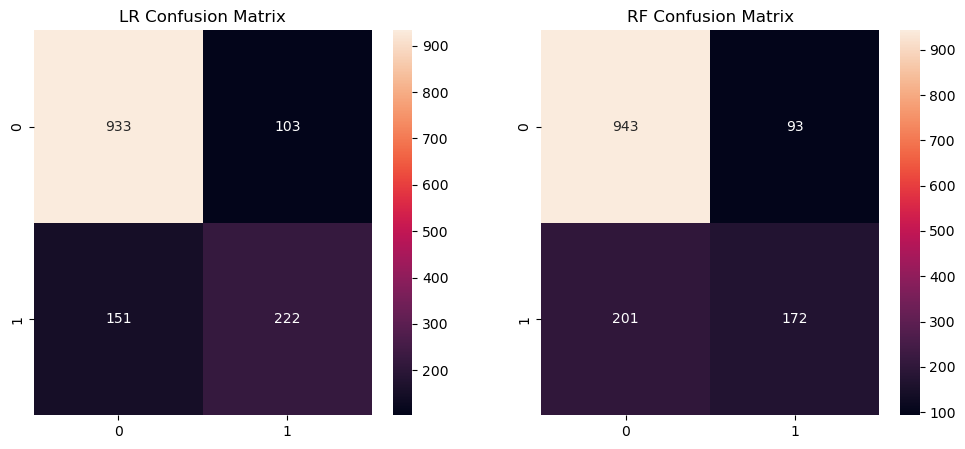

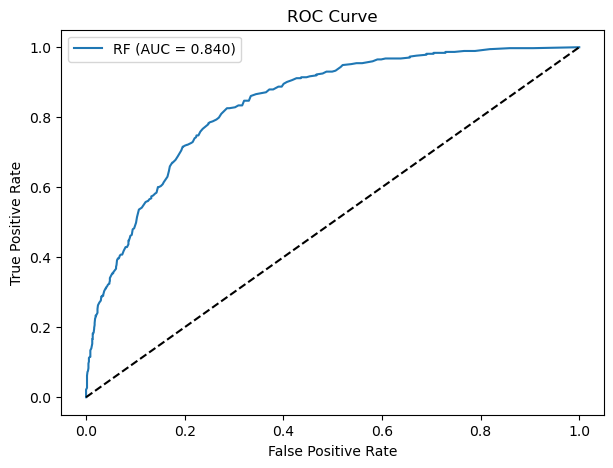

In [14]:
# Confusion Matrix and ROC curve 
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# Confusion matrices
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', ax=axes[0])
axes[0].set_title("LR Confusion Matrix")
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', ax=axes[1])
axes[1].set_title("RF Confusion Matrix")
plt.show()

# ROC for Random Forest (example)
y_proba_rf = pipe_rf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7,5))
plt.plot(fpr,tpr,label=f'RF (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


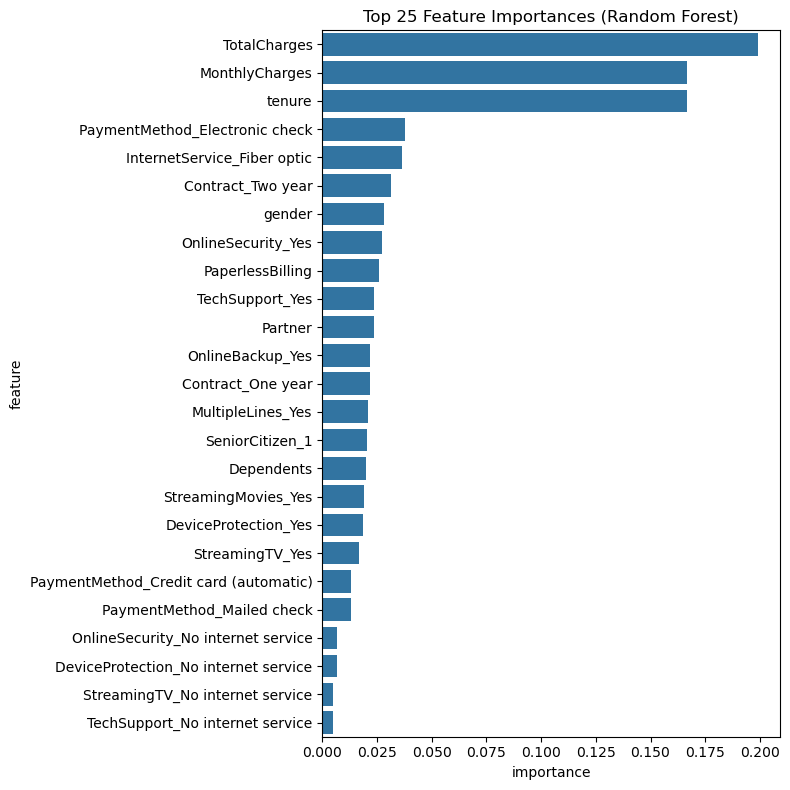

In [15]:
# Feature importance (Random Forest) 
# Extract feature importances from RF
rf = pipe_rf.named_steps['rf']
importances = rf.feature_importances_
feat_names = X_train.columns
feat_imp = pd.DataFrame({'feature':feat_names, 'importance':importances}).sort_values('importance', ascending=False).head(25)
plt.figure(figsize=(8,8))
sns.barplot(x='importance', y='feature', data=feat_imp)
plt.title("Top 25 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


In [16]:
# Hyperparameter tuning (GridSearch) for Random Forest

param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 8, 12],
    'rf__min_samples_split': [2, 5]
}
gs = GridSearchCV(pipe_rf, param_grid, cv=3, scoring='f1', n_jobs=-1)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
best_model = gs.best_estimator_
print_metrics(y_test, best_model.predict(X_test), "Best RF (GridSearch)")


Best params: {'rf__max_depth': 12, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
=== Best RF (GridSearch) ===
Accuracy: 0.8055358410220014
Precision: 0.6749116607773852
Recall: 0.5120643431635389
F1: 0.5823170731707317
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1036
           1       0.67      0.51      0.58       373

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409



In [17]:
# Save the final model and scaler 
os.makedirs("artifacts", exist_ok=True)
joblib.dump(pipe_rf, "artifacts/random_forest_pipeline.joblib")

# Save columns used (for future inference)
pd.Series(X.columns).to_csv("artifacts/feature_columns.csv", index=False)
print("Saved model and feature columns.")


Saved model and feature columns.


In [18]:
# Save ROC plot, confusion matrix, feature importance images using matplotlib savefig()

plt.figure(figsize=(6,4))
plt.plot(fpr,tpr,label=f'RF (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()
plt.savefig("artifacts/roc_curve.png", dpi=150, bbox_inches='tight')
plt.close()
